# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

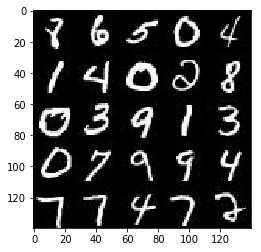

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

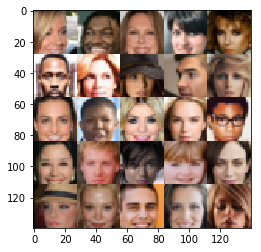

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/danilo.herrera/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(value, alpha=0.2):
    return tf.maximum(alpha * value, value)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = lrelu(x1)
        # 14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = lrelu(bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = lrelu(bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    def lrelu(value, alpha = 0.2):
        return tf.maximum(alpha * value, value)
    
    initial_width = 3
    initial_height = 3
    initial_depth = 512
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully connected layer
        x1 = tf.layers.dense(z, initial_width*initial_height*initial_depth)
        
        # Reshape it to start the convnet
        x1 = tf.reshape(x1, (-1, initial_width, initial_height, initial_depth))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # 3x3x512
        
        x2 = tf.layers.conv2d_transpose(x1, int(initial_depth/2), 5, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, int(initial_depth/4), 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x{out_channel_dim}
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    label_smoothing = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - label_smoothing)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)* label_smoothing))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
class GAN:
    def __init__(self, image_width, image_height, image_channels, z_dim):
        self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, image_channels)
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, 0.5)

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_text_every=10, print_images_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    n_samples, width, height, channels = data_shape
    gan = GAN(width, height, channels, z_dim)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for x in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(gan.d_opt, feed_dict={gan.input_real: x, gan.input_z: batch_z, gan.learning_rate: learning_rate})
                _ = sess.run(gan.g_opt, feed_dict={gan.input_z: batch_z, gan.learning_rate: learning_rate})
                
                if steps % print_text_every == 0:
                    train_loss_d = gan.d_loss.eval({gan.input_z: batch_z, gan.input_real: x})
                    train_loss_g = gan.g_loss.eval({gan.input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % print_images_every == 0:
                    show_generator_output(sess, 16, gan.input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 1.1199
Epoch 1/2... Discriminator Loss: 0.9316... Generator Loss: 0.9966
Epoch 1/2... Discriminator Loss: 2.1798... Generator Loss: 0.1753
Epoch 1/2... Discriminator Loss: 1.5122... Generator Loss: 0.4502
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.7131... Generator Loss: 0.2913
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 1.2682
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 0.8558
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.9868
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 0.7308


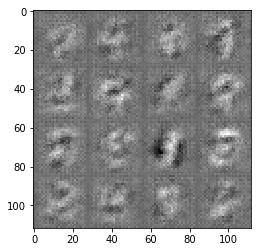

Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 1.0844... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 1.2990
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 0.8893... Generator Loss: 1.3229
Epoch 1/2... Discriminator Loss: 0.9463... Generator Loss: 2.0078
Epoch 1/2... Discriminator Loss: 0.8801... Generator Loss: 1.0048
Epoch 1/2... Discriminator Loss: 1.0392... Generator Loss: 0.7388


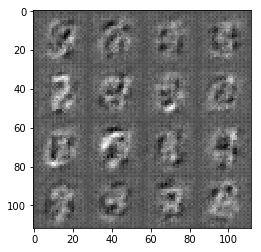

Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.9682
Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 2.2385
Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 2.1601
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 3.1577
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 1.0282
Epoch 1/2... Discriminator Loss: 1.9968... Generator Loss: 0.2120
Epoch 1/2... Discriminator Loss: 0.8811... Generator Loss: 1.6827
Epoch 1/2... Discriminator Loss: 0.7946... Generator Loss: 1.5083
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 0.6603
Epoch 1/2... Discriminator Loss: 0.7534... Generator Loss: 1.6121


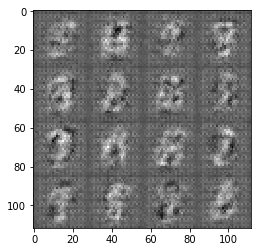

Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 1.6228
Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 1.9664
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 1.4337
Epoch 1/2... Discriminator Loss: 0.8682... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 0.9042... Generator Loss: 0.9557
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 1.6328
Epoch 1/2... Discriminator Loss: 0.8440... Generator Loss: 2.0509
Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 1.7323
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 0.7997... Generator Loss: 1.3513


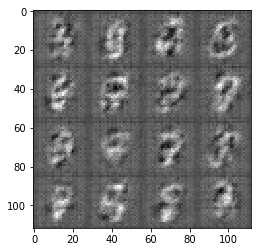

Epoch 1/2... Discriminator Loss: 0.8387... Generator Loss: 1.1532
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 2.7007
Epoch 1/2... Discriminator Loss: 0.8364... Generator Loss: 1.1085
Epoch 1/2... Discriminator Loss: 0.7461... Generator Loss: 2.2718
Epoch 1/2... Discriminator Loss: 0.7675... Generator Loss: 1.4412
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.5261
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 1.1110
Epoch 1/2... Discriminator Loss: 0.7689... Generator Loss: 1.3218
Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 1.2937
Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 0.9997


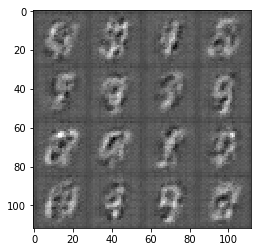

Epoch 1/2... Discriminator Loss: 0.7231... Generator Loss: 1.7391
Epoch 1/2... Discriminator Loss: 0.7498... Generator Loss: 1.6774
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 0.9585
Epoch 1/2... Discriminator Loss: 0.7326... Generator Loss: 1.5421
Epoch 1/2... Discriminator Loss: 0.7259... Generator Loss: 2.0882
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 1.9535
Epoch 1/2... Discriminator Loss: 0.7382... Generator Loss: 1.5610
Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 1.7254
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 1.7717
Epoch 1/2... Discriminator Loss: 0.7244... Generator Loss: 1.7632


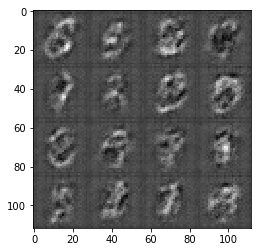

Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 1.1510
Epoch 1/2... Discriminator Loss: 0.7484... Generator Loss: 1.7300
Epoch 1/2... Discriminator Loss: 0.8105... Generator Loss: 1.1840
Epoch 1/2... Discriminator Loss: 0.8434... Generator Loss: 1.1055
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.5425
Epoch 1/2... Discriminator Loss: 0.9137... Generator Loss: 2.6235
Epoch 1/2... Discriminator Loss: 0.7297... Generator Loss: 1.9105
Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 1.4732
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.0851
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 1.7590


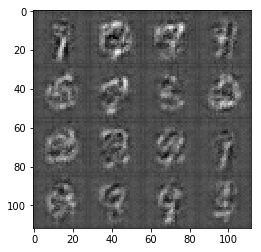

Epoch 1/2... Discriminator Loss: 0.7149... Generator Loss: 2.0546
Epoch 1/2... Discriminator Loss: 0.7273... Generator Loss: 1.5483
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.7083
Epoch 1/2... Discriminator Loss: 0.7166... Generator Loss: 1.6429
Epoch 1/2... Discriminator Loss: 0.7178... Generator Loss: 1.9341
Epoch 1/2... Discriminator Loss: 0.7374... Generator Loss: 1.4721
Epoch 1/2... Discriminator Loss: 0.7057... Generator Loss: 1.6653
Epoch 1/2... Discriminator Loss: 0.7400... Generator Loss: 1.4838
Epoch 1/2... Discriminator Loss: 0.7097... Generator Loss: 1.7228
Epoch 1/2... Discriminator Loss: 0.7214... Generator Loss: 1.9988


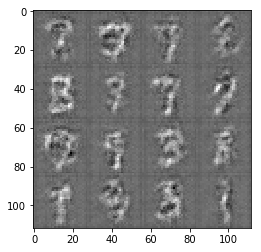

Epoch 1/2... Discriminator Loss: 1.1070... Generator Loss: 0.6853
Epoch 1/2... Discriminator Loss: 0.7418... Generator Loss: 1.6443
Epoch 1/2... Discriminator Loss: 0.6970... Generator Loss: 1.7245
Epoch 1/2... Discriminator Loss: 0.8534... Generator Loss: 1.0488
Epoch 1/2... Discriminator Loss: 0.7425... Generator Loss: 1.4460
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 0.7167... Generator Loss: 1.5437
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 1.5426
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 1.7203
Epoch 1/2... Discriminator Loss: 0.7448... Generator Loss: 1.4168


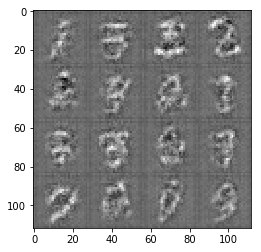

Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 1.0767
Epoch 1/2... Discriminator Loss: 0.7235... Generator Loss: 1.9045
Epoch 1/2... Discriminator Loss: 0.8317... Generator Loss: 1.0866
Epoch 2/2... Discriminator Loss: 0.7541... Generator Loss: 2.4947
Epoch 2/2... Discriminator Loss: 0.7359... Generator Loss: 1.5049
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.3591
Epoch 2/2... Discriminator Loss: 0.7041... Generator Loss: 1.7942
Epoch 2/2... Discriminator Loss: 0.7494... Generator Loss: 1.5716
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.4591
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 1.1211


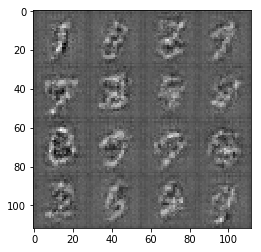

Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 1.8749
Epoch 2/2... Discriminator Loss: 0.9523... Generator Loss: 0.8449
Epoch 2/2... Discriminator Loss: 0.7998... Generator Loss: 1.1739
Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 1.5310
Epoch 2/2... Discriminator Loss: 0.6965... Generator Loss: 1.7071
Epoch 2/2... Discriminator Loss: 0.7458... Generator Loss: 1.6891
Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 1.4671
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.0267
Epoch 2/2... Discriminator Loss: 0.7308... Generator Loss: 1.6816
Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 1.3122


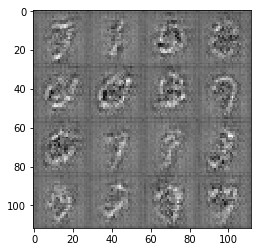

Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 1.2286
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 2.2029
Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 1.6326
Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 1.5604
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 1.0353
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 1.3463
Epoch 2/2... Discriminator Loss: 0.7618... Generator Loss: 1.3839
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.8966
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 0.5561
Epoch 2/2... Discriminator Loss: 0.8414... Generator Loss: 1.3000


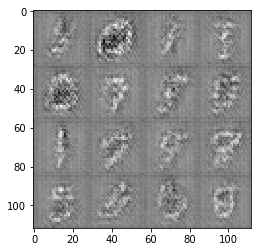

Epoch 2/2... Discriminator Loss: 0.7371... Generator Loss: 1.4805
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 1.2723
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.5399
Epoch 2/2... Discriminator Loss: 0.7016... Generator Loss: 1.6646
Epoch 2/2... Discriminator Loss: 0.7340... Generator Loss: 1.4823
Epoch 2/2... Discriminator Loss: 0.8113... Generator Loss: 1.1329
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.4709
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 1.3234
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 1.8666
Epoch 2/2... Discriminator Loss: 0.7145... Generator Loss: 1.5586


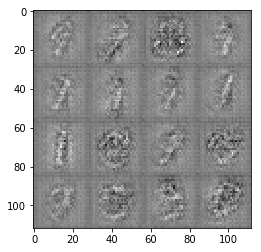

Epoch 2/2... Discriminator Loss: 0.7035... Generator Loss: 1.6361
Epoch 2/2... Discriminator Loss: 0.9112... Generator Loss: 0.9049
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 1.0844
Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 1.3957
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.7147
Epoch 2/2... Discriminator Loss: 0.7643... Generator Loss: 1.3001
Epoch 2/2... Discriminator Loss: 0.7095... Generator Loss: 1.8252
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 1.3872
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.3708
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 0.8770


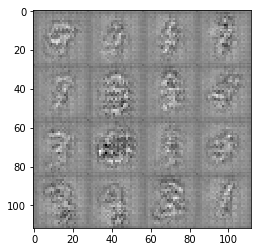

Epoch 2/2... Discriminator Loss: 0.7998... Generator Loss: 1.2032
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.3602
Epoch 2/2... Discriminator Loss: 0.9105... Generator Loss: 2.4468
Epoch 2/2... Discriminator Loss: 0.7272... Generator Loss: 1.5332
Epoch 2/2... Discriminator Loss: 0.7239... Generator Loss: 1.4835
Epoch 2/2... Discriminator Loss: 0.8297... Generator Loss: 1.0711
Epoch 2/2... Discriminator Loss: 0.9729... Generator Loss: 0.8101
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 1.0658
Epoch 2/2... Discriminator Loss: 0.7277... Generator Loss: 1.4589
Epoch 2/2... Discriminator Loss: 0.7353... Generator Loss: 2.1293


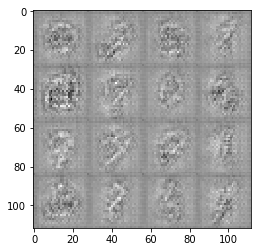

Epoch 2/2... Discriminator Loss: 0.7151... Generator Loss: 1.5211
Epoch 2/2... Discriminator Loss: 0.7187... Generator Loss: 1.4875
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.5580
Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 2.0851
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 1.1844
Epoch 2/2... Discriminator Loss: 0.7237... Generator Loss: 1.4511
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.4321
Epoch 2/2... Discriminator Loss: 0.7007... Generator Loss: 1.6265


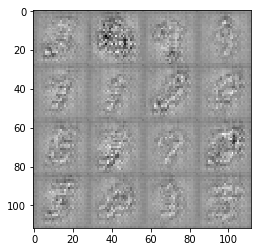

Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 1.0955
Epoch 2/2... Discriminator Loss: 0.7008... Generator Loss: 1.6532
Epoch 2/2... Discriminator Loss: 0.7046... Generator Loss: 1.7962
Epoch 2/2... Discriminator Loss: 0.7093... Generator Loss: 1.7480
Epoch 2/2... Discriminator Loss: 0.6879... Generator Loss: 1.9088
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 1.5436
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 3.2772
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 1.8474
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.0906
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 1.2310


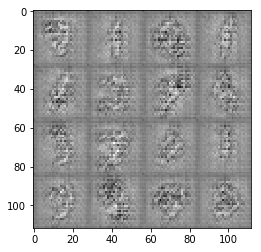

Epoch 2/2... Discriminator Loss: 0.7437... Generator Loss: 1.4595
Epoch 2/2... Discriminator Loss: 0.7064... Generator Loss: 1.8759
Epoch 2/2... Discriminator Loss: 0.7977... Generator Loss: 1.1721
Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 0.8313
Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 1.6424
Epoch 2/2... Discriminator Loss: 0.7845... Generator Loss: 1.2219
Epoch 2/2... Discriminator Loss: 0.7064... Generator Loss: 1.6933
Epoch 2/2... Discriminator Loss: 0.7326... Generator Loss: 1.4237
Epoch 2/2... Discriminator Loss: 0.8173... Generator Loss: 1.1188
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.1387


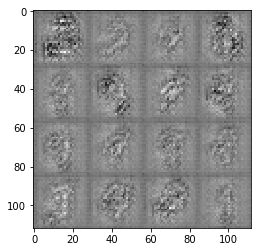

Epoch 2/2... Discriminator Loss: 0.7125... Generator Loss: 1.5535
Epoch 2/2... Discriminator Loss: 0.8678... Generator Loss: 1.0268
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.2604
Epoch 2/2... Discriminator Loss: 0.7576... Generator Loss: 1.6364
Epoch 2/2... Discriminator Loss: 0.7066... Generator Loss: 1.5726
Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 1.9401
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 1.4088


In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.6337
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.1207
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.7147


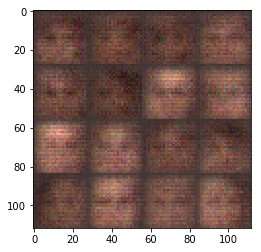

Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.5297
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.5527
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.6679
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.6811
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 1.6770
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 2.3288


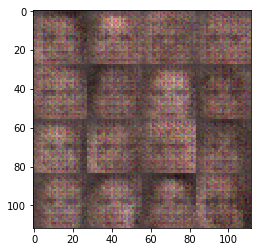

Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.4805
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 1.8165... Generator Loss: 0.2538
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 2.9442
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 2.7677
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7150


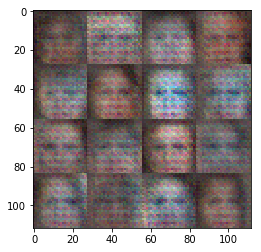

Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.8440
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.3751
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.4866
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 2.3882
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.7990


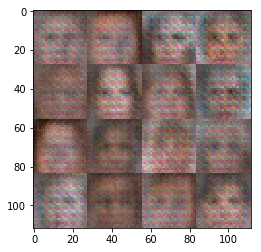

Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 2.2884
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 1.9730
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 2.9509
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 2.6173
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 2.1781
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.6791


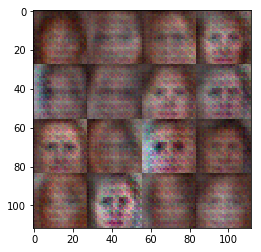

Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 2.8070
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 3.2304
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.7869
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.9167
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 2.4746
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 2.8751
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.3266


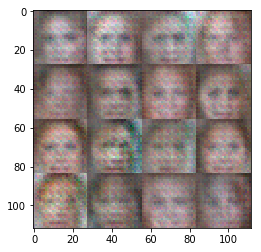

Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 2.2485
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 2.0628
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 3.9368
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.3905
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 2.4226
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.5330
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 2.8827
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.8311


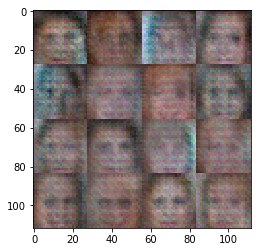

Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.5729
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 4.3498
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.3228
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 2.5165
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 2.8977
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.8513... Generator Loss: 0.2289
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.9307


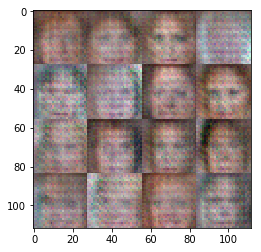

Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.4296
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 2.7763
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.1799
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 5.3329
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.9423
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 2.6053
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.8290
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 2.1438


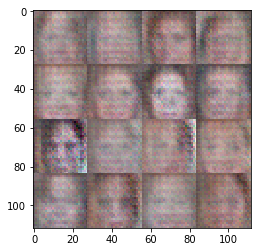

Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 3.5358
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.3649
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 4.4856
Epoch 1/1... Discriminator Loss: 0.7105... Generator Loss: 1.6419
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 3.5892
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 0.7278... Generator Loss: 1.5603
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.3893
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.9261


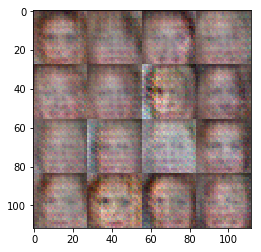

Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 4.4575
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.9141
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 4.5836
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.6313
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.7976
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 2.3357
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 4.0057
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 2.7249


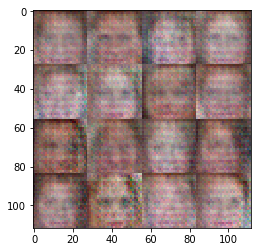

Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.9327
Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 1.3756
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 3.6278
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.1728
Epoch 1/1... Discriminator Loss: 1.7203... Generator Loss: 0.2674
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 2.0227


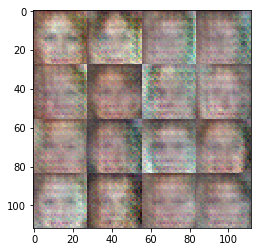

Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 2.0526
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 5.2004
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 5.9747
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 3.1505
Epoch 1/1... Discriminator Loss: 0.7394... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 3.8745
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 4.5685
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 2.4975


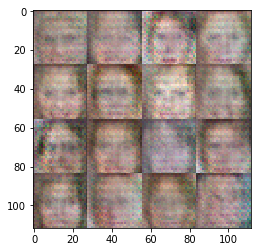

Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 2.5155
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.5570
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 3.5143
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 2.9904
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 2.5055
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 2.0128
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 2.5723
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.5056


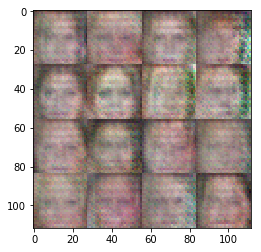

Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 3.7761
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 3.5788
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.3740
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 4.8855
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 1.8660
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 3.0248
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 4.5657
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 3.6041


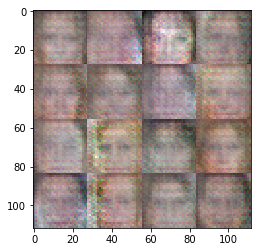

Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 3.5685
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.3783
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.4198
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.4267
Epoch 1/1... Discriminator Loss: 2.3231... Generator Loss: 0.1246
Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 2.0357
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.5236


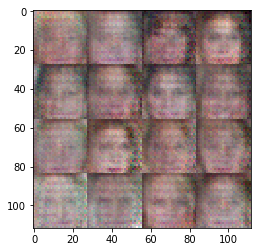

Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 5.1669
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.3309
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 4.1032
Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 2.2890
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.1536
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 4.0469
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 1.9110
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 4.1619
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 0.9915


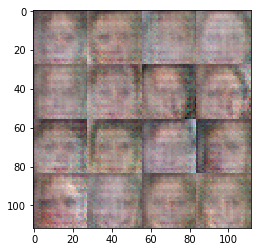

Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 0.7184... Generator Loss: 1.5785
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 3.2497
Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 1.8912
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 3.4373
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.5063
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 2.8989
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 2.0018
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 3.7713


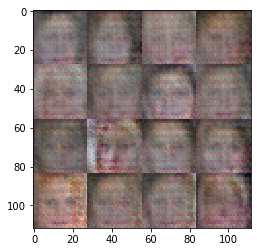

Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 3.2348
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 2.8283
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.7489
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 2.5710
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 3.0043
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 2.7561
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 2.2330
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 4.1299
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 2.0244
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.6911


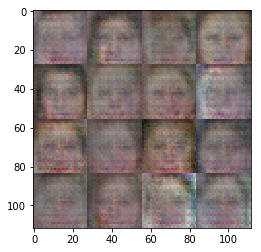

Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 2.1096
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 2.3400
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 3.7440
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 4.0397
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 2.2250
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 3.7239
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 4.4489
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 2.1674
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 2.9755


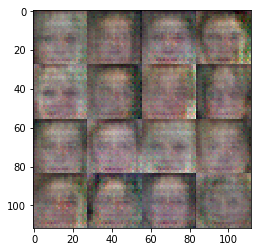

Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 3.2050
Epoch 1/1... Discriminator Loss: 0.6618... Generator Loss: 2.4172
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 2.9096
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 3.5040
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 2.8260
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 5.4742
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.9483


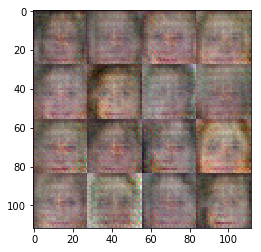

Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 2.1092
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 2.9338
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.5328
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 4.2808
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 2.0551
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 4.3543
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 2.4681
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 4.3088
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 3.0196


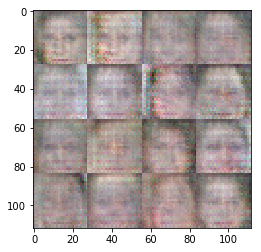

Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.1842
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 3.1731
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 4.1225
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 2.1927
Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 2.6421
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 2.4607
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 2.3978
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 2.2100


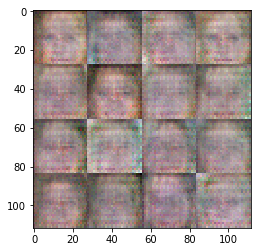

Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 2.1011
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 2.3673
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 3.2312
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 2.0794
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 2.9411
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 1.9700
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 1.8726
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 2.4920
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.8702


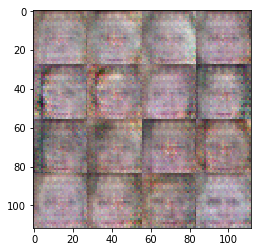

Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 1.9555
Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 2.5721
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 2.0979
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.8839
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 2.6544
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 1.9962
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 2.2904
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.5094
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.4698
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 1.8767


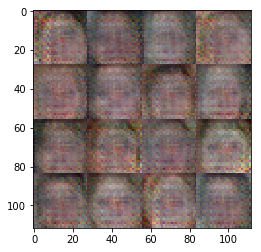

Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 1.8818
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.8270
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 2.1943
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.9739
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 2.1462
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 2.1274
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 2.0191
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 2.9889


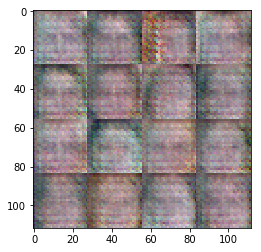

Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 1.9526
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 3.5125
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 2.2148
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 2.1790
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 3.0448
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 2.7188
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 1.9868
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 2.2821
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 3.6811
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 2.1350


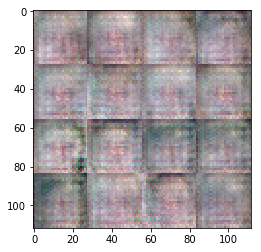

Epoch 1/1... Discriminator Loss: 0.6636... Generator Loss: 2.1174
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 2.5612
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 2.1593
Epoch 1/1... Discriminator Loss: 0.6618... Generator Loss: 1.9926
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 2.6416
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 2.0551
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 2.3081
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 2.5456
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 4.9534


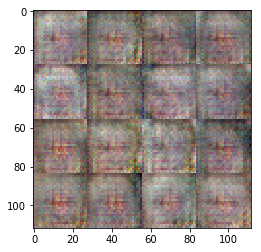

Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 2.7693
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 2.1488
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.5858
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 2.5512
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 2.2519
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 2.1617
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 2.0265
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 3.1891
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 2.2350
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 2.2982


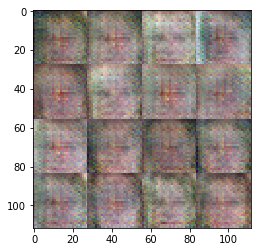

Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 2.3099
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 2.2335
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 2.3726
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.9768
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 2.2887
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 2.1901
Epoch 1/1... Discriminator Loss: 0.6588... Generator Loss: 2.2283
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 2.0676
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 2.1012
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.7095


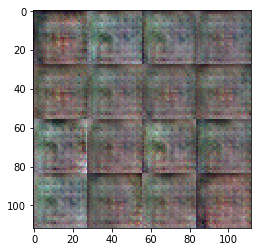

Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 4.2175
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 0.6658... Generator Loss: 2.0282
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 2.2128
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 2.0830
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 2.2781
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 2.2001
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 3.5369
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 2.5617


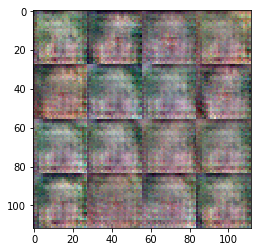

Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 2.7604
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 3.1872
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.9077
Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 2.4072
Epoch 1/1... Discriminator Loss: 0.6636... Generator Loss: 2.3189
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 2.2185


In [30]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.